# 3P - Model Evaluation

In [1]:
from os import path

import numpy as np
import h5py
from tqdm import tqdm
from keras.models import load_model

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from rnn_tauid.common.mpl_setup import mpl_setup
mpl_setup()

Using Theano backend.


Input files:

In [2]:
# Sample paths
sig_jet_fname = "/lustre/user/cdeutsch/rnn-samples-v4/sig3P_jet.h5"
bkg_jet_fname = "/lustre/user/cdeutsch/rnn-samples-v4/bkg3P_jet_shuffle.h5"
sig_cluster_fname = "/lustre/user/cdeutsch/rnn-samples-v4/sig3P_cluster.h5"
bkg_cluster_fname = "/lustre/user/cdeutsch/rnn-samples-v4/bkg3P_cluster_shuffle.h5"

# Model files
model_fname = "/lustre/user/cdeutsch/rnn-feature-samples-v4/saved_models/cluster_3p_valloss_0_3967/model.h5"
preprocessing_fname = "/lustre/user/cdeutsch/rnn-feature-samples-v4/saved_models/cluster_3p_valloss_0_3967/preproc.h5"

# Plot output prefix
plot_prefix = "/lustre/user/cdeutsch/rnn-feature-samples-v4/saved_models/cluster_3p_valloss_0_3967/plots/"

In [3]:
# Tau-level datasets
sigf_jet = h5py.File(sig_jet_fname, "r")
bkgf_jet = h5py.File(bkg_jet_fname, "r")
sig_jet = sigf_jet["jet"]
bkg_jet = bkgf_jet["jet"]

# Cluster-level datasets
sigf_cluster = h5py.File(sig_cluster_fname, "r")
bkgf_cluster = h5py.File(bkg_cluster_fname, "r")
sig_cluster = sigf_cluster["cluster"]
bkg_cluster = bkgf_cluster["cluster"]

In [4]:
with h5py.File(preprocessing_fname, "r") as f:
    invars = np.char.decode(f["variables"][...]).tolist()
    offset = {v: f[v + "/offset"][...] for v in invars}
    scale = {v: f[v + "/scale"][...] for v in invars}

n_vars = len(invars)
n_clusters = len(offset[invars[0]])

In [5]:
model = load_model(model_fname)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 6, 12)         0                                            
____________________________________________________________________________________________________
masking_1 (Masking)              (None, 6, 12)         0           input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 6, 32)         416         masking_1[0][0]                  
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 24)            5472        timedistributed_1[0][0]          
___________________________________________________________________________________________

In [6]:
# Get the testing slice
total_frac = 0.2
test_start = int(total_frac * min(len(sig_cluster), len(bkg_cluster)))
print("[{}:] for testing".format(test_start))

[529265:] for testing


In [7]:
sig_pred = np.zeros(len(sig_cluster) - test_start, dtype=np.float32)
bkg_pred = np.zeros(len(bkg_cluster) - test_start, dtype=np.float32)

In [8]:
buf_size = 512 * 1024**2 // (4 * n_clusters * n_vars)  # 512 MB buffer
buf = np.empty((buf_size, n_clusters, n_vars), dtype=np.float32)

In [9]:
for cluster, jet, pred in [(sig_cluster, sig_jet, sig_pred), (bkg_cluster, bkg_jet, bkg_pred)]:
    chunks = [(start, min(start + buf_size, len(cluster))) for start in range(test_start, len(cluster), buf_size)]
    pred_idx = 0

    for start, stop in tqdm(chunks):
        # Fill buffer
        n_write = stop - start
        for i, var in enumerate(invars):
            # Read variable into buffer
            buf_view = buf[:n_write, :, i]
            buf_view[...] = cluster[start:stop, :n_clusters, var]

            # Apply preprocessing
            buf_view -= offset[var]
            buf_view /= scale[var]

            # Remove nan
            buf_view[np.isnan(buf_view)] = 0

        # Predict
        pred[pred_idx:pred_idx + n_write] = model.predict(buf[:n_write], batch_size=512).ravel()
        pred_idx += n_write

    assert pred_idx == len(pred)

del buf

100%|██████████| 8/8 [19:32<00:00, 144.51s/it]


## Evaluation plots

In [10]:
from sklearn.metrics import roc_auc_score
from scipy.interpolate import interp1d

In [11]:
from rnn_tauid.evaluation.misc import roc_curve, binned_efficiency
from rnn_tauid.evaluation.flattener import Flattener

### R21 $\tau$-ID

/lustre/user/cdeutsch/miniconda2/envs/ML/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


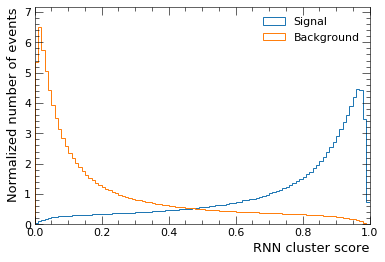

In [12]:
histopt = dict(bins=100, range=(0, 1), normed=True, histtype="step")
plt.hist(sig_pred, label="Signal", **histopt)
plt.hist(bkg_pred, label="Background", **histopt)
plt.xlabel("RNN cluster score", ha="right", x=1.0)
plt.ylabel("Normalized number of events", ha="right", y=1.0)
lo, hi = plt.ylim()
plt.ylim((lo, 1.1 * hi))
plt.legend()

plt.savefig(path.join(plot_prefix, "cluster_score_1p.pdf"))

In [13]:
y_true = np.concatenate([np.ones_like(sig_pred), np.zeros_like(bkg_pred)])
y_score = np.concatenate([sig_pred, bkg_pred])

auc = roc_auc_score(y_true, y_score)
eff, rej = roc_curve(y_true, y_score)

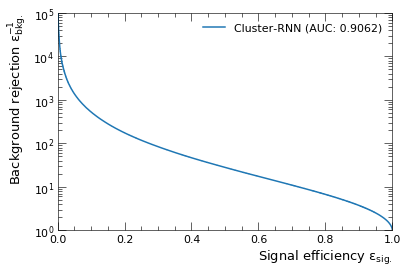

In [14]:
plt.plot(eff, rej, label="Cluster-RNN (AUC: {:.4})".format(auc))
plt.yscale("log")
plt.xlim((0.0, 1.0))
plt.xlabel(r"Signal efficiency $\varepsilon_\mathrm{sig.}$", ha="right", x=1.0)
plt.ylim((1e0, 1e5))
plt.ylabel(r"Background rejection $\varepsilon_\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.legend()

plt.savefig(path.join(plot_prefix, "cluster_roc_1p.pdf"))

### $p_\mathrm{T}$ / $\mu$-flattening and working point calculation

In [38]:
wp_eff = 0.45
pt_bins = np.array([
    20000., 25178., 31697., 39905., 50237., 63245., 79621., 100000.,
    130000., 200000., 316978., 502377., 796214., 1261914., 2000000.
])
mu_bins = np.array([
    -0.5, 10.5, 19.5, 23.5, 27.5, 31.5, 35.5, 39.5, 49.5, 61.5
])

In [39]:
flat = Flattener(pt_bins, mu_bins, wp_eff)

passes_thr = flat.fit(sig_jet["TauJets.pt"][test_start:],
                      sig_jet["TauJets.mu"][test_start:],
                      sig_pred)

assert np.isclose(np.count_nonzero(passes_thr) / float(len(passes_thr)), wp_eff, atol=0, rtol=1e-2)

#### Cluster-RNN

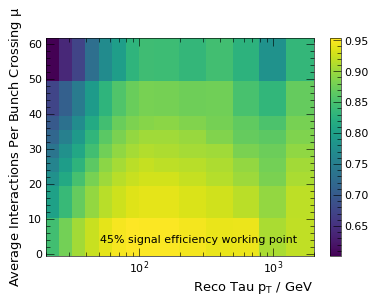

In [40]:
X, Y = np.meshgrid(flat.x_bins, flat.y_bins)
plt.pcolormesh(X / 1000.0, Y, flat.cutmap.T)
plt.xscale("log")
plt.xlabel(r"Reco Tau $p_\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel(r"Average Interactions Per Bunch Crossing $\mu$")
plt.annotate("{:.0%} signal efficiency working point".format(wp_eff), xy=(0.94, 0.06), xycoords="axes fraction", horizontalalignment="right")
plt.colorbar()
plt.savefig(path.join(plot_prefix, "cluster_wp_cutmap_1p.pdf"))

In [41]:
pt = sig_jet["TauJets.pt"][test_start:]

bins = np.percentile(pt, np.linspace(0.0, 100.0, 40))
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

eff_pt = binned_efficiency(pt, passes_thr, bins=bins)

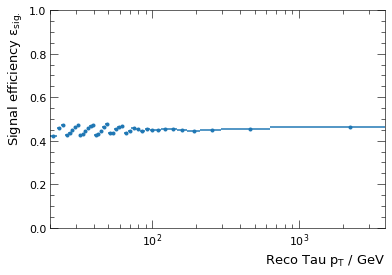

In [42]:
plt.errorbar(bin_midpoint / 1000.0, eff_pt.mean, xerr=bin_half_width / 1000.0, yerr=eff_pt.std, fmt=".")
plt.ylim((0.0, 1.0))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "cluster_wp_eff_1p.pdf"))

In [43]:
nVtxPU = sig_jet["TauJets.nVtxPU"][test_start:]

bins = np.array([0, 10, 12, 14, 16, 18, 20, 22, 24, 50])
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

eff_nVtx = binned_efficiency(nVtxPU, passes_thr, bins=bins)

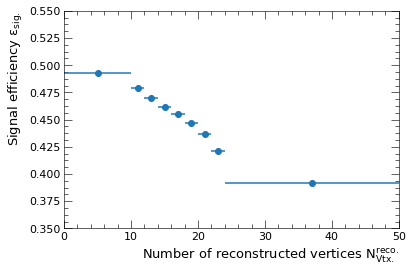

In [44]:
plt.errorbar(bin_midpoint, eff_nVtx.mean, xerr=bin_half_width, yerr=eff_nVtx.std, fmt="o")
plt.ylim((0.35, 0.55))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Signal efficiency $\\varepsilon_\\mathrm{sig.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "cluster_wp_eff_nVtx_1p.pdf"))

In [45]:
bkg_pass_thr = flat.passes_thr(bkg_jet["TauJets.pt"][test_start:], bkg_jet["TauJets.mu"][test_start:], bkg_pred)

bins = 10 ** np.linspace(np.log10(20000), np.log10(300000), 11)
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

bkg_eff_pt = binned_efficiency(bkg_jet["TauJets.pt"][test_start:], bkg_pass_thr, bins=bins)

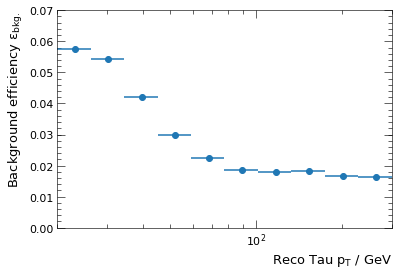

In [46]:
plt.errorbar(bin_midpoint / 1000.0, bkg_eff_pt.mean, xerr=bin_half_width / 1000.0, yerr=bkg_eff_pt.std, fmt="o")
plt.ylim((0.0, 0.07))
plt.xscale("log")
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background efficiency $\\varepsilon_\\mathrm{bkg.}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "cluster_wp_bkgeff_1p.pdf"))

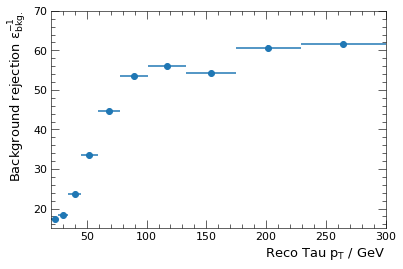

In [48]:
rej = np.reciprocal(bkg_eff_pt.mean)
drej = bkg_eff_pt.std / bkg_eff_pt.mean**2

plt.errorbar(bin_midpoint / 1000.0, rej, xerr=bin_half_width / 1000.0, yerr=drej, fmt="o")
plt.xlim((20, 300))
plt.ylim((15, 70))
plt.xlabel("Reco Tau $p_\\mathrm{T}$ / GeV", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "cluster_rejection_1p.pdf"))

In [49]:
mu = bkg_jet["TauJets.mu"][test_start:]

bins = mu_bins
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

bkg_eff_mu = binned_efficiency(mu, bkg_pass_thr, bins=bins)

rej_mu = np.reciprocal(bkg_eff_mu.mean)
drej_mu = bkg_eff_mu.std / bkg_eff_mu.mean**2

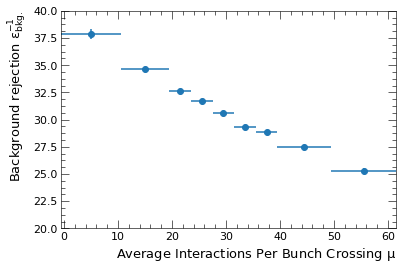

In [50]:
plt.errorbar(bin_midpoint, rej_mu, xerr=bin_half_width, yerr=drej_mu, fmt="o")
plt.ylim((20, 40))
plt.xlabel("Average Interactions Per Bunch Crossing $\\mu$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "cluster_rejection_mu_1p.pdf"))

In [51]:
nVtx = bkg_jet["TauJets.nVtxPU"][test_start:]

bins = np.array([0, 10, 12, 14, 16, 18, 20, 22, 24, 50])
bin_midpoint = (bins[1:] + bins[:-1]) / 2.0
bin_half_width = (bins[1:] - bins[:-1]) / 2.0

bkg_eff_nVtx = binned_efficiency(nVtx, bkg_pass_thr, bins=bins)

rej_nVtx = np.reciprocal(bkg_eff_nVtx.mean)
drej_nVtx = bkg_eff_nVtx.std / bkg_eff_nVtx.mean**2

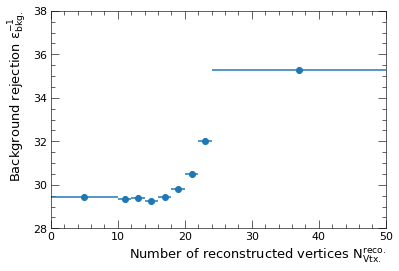

In [56]:
plt.errorbar(bin_midpoint, rej_nVtx, xerr=bin_half_width, yerr=drej_nVtx, fmt="o")
plt.ylim((28, 38))
plt.xlabel("Number of reconstructed vertices $N_\\mathrm{Vtx.}^\\mathrm{reco.}$", ha="right", x=1.0)
plt.ylabel("Background rejection $\\varepsilon_\\mathrm{bkg.}^{-1}$", ha="right", y=1.0)
plt.savefig(path.join(plot_prefix, "cluster_rejection_nVtx_1p.pdf"))

In [57]:
sigf_jet.close()
bkgf_jet.close()
sigf_cluster.close()
bkgf_cluster.close()